# Introduction
- nb25 の編集
- pytorch を使った最小限のノートブック
- ref:
    > https://www.kaggle.com/todnewman/keras-neural-net-for-champs

# Import everything I need :)

In [1]:
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import lightgbm as lgb
from fastprogress import progress_bar

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Preparation

In [2]:
nb = 37
isSmallSet = True
length = 20000
is_cuda = torch.cuda.is_available()
print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(3))

False


In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv',
 '../input/champs-scalar-coupling/structures.zip',
 '../input/champs-scalar-coupling/train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/sample_submission.csv',
 '../input/champs-scalar-coupling/nb29_fc_test_feature.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/nb29_fc_train_feature.csv']

In [5]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)

In [6]:
# test
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path)[:length]
else:
    test = pd.read_csv(path)

In [7]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [8]:
if isSmallSet:
    print('using SmallSet !!')
    print('-------------------')

print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

using SmallSet !!
-------------------
There are 20000 rows in train data.
There are 20000 rows in test data.
There are 612 distinct molecules in train data.
There are 549 distinct molecules in test data.
There are 19 unique atoms.
There are 8 unique types.


---
## myFunc
**metrics**

In [9]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

---
**momory**

In [10]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Feature Engineering

**basic**

In [11]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df


for atom_idx in [0,1]:
    train = map_atom_info(train, structures, atom_idx)
    test  = map_atom_info(test, structures, atom_idx)
    
    train = train.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}'})
    test  =  test.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}'})

`type` の特徴量から、数字を抽出  
例) 2JHC ---> 2

In [12]:
def create_type0(df):
    df['type_0'] = df['type'].apply(lambda x : x[0])
    return df
# train['type_0'] = train['type'].apply(lambda x: x[0])
# test['type_0'] = test['type'].apply(lambda x: x[0])

distances

In [13]:
def distances(df):
    df_p_0 = df[['x_0', 'y_0', 'z_0']].values
    df_p_1 = df[['x_1', 'y_1', 'z_1']].values
    
    df['dist'] = np.linalg.norm(df_p_0 - df_p_1, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    
    return df

# train = distances(train)
# test  = distances(test)

In [14]:
%%time

train = create_type0(train)
test  = create_type0(test)

train = distances(train)
test  = distances(test)

CPU times: user 27.3 ms, sys: 2.81 ms, total: 30.1 ms
Wall time: 30.5 ms


---
<br>
<br>
<br>
カテゴリカル特徴量 と 数値特徴量

In [15]:
cat_cols = ['atom_1','type_0','type']
num_cols = list(set(train.columns) - set(cat_cols) - set(["scalar_coupling_constant", 'molecule_name', 'id', 'atom_0']))
print(f'カテゴリカル: {cat_cols}')
print(f'数値:        {num_cols}')

カテゴリカル: ['atom_1', 'type_0', 'type']
数値:        ['dist', 'dist_z', 'atom_index_1', 'z_1', 'dist_y', 'y_1', 'atom_index_0', 'y_0', 'x_0', 'x_1', 'dist_x', 'z_0']


<br>
<br>
<br>

LabelEncode
- `atom_1` = {H, C, N}
- `type_0` = {1, 2, 3}
- `type`   = {2JHC, ...}

In [16]:
for f in ['atom_1', 'type_0', 'type']:
    if f in train.columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

<br>
<br>
<br>
標準化

In [17]:
train[num_cols] = train[num_cols].fillna(0)
test[num_cols]  =  test[num_cols].fillna(0)
print('scaling numerical columns')

scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

scaling numerical columns


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


---
**show features**

In [18]:
train.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,type_0,dist,dist_x,dist_y,dist_z
0,0,dsgdb9nsd_000001,-3.168369,-1.112064,0,84.8076,H,-0.037852,-0.098007,-0.008894,0,-0.045678,0.792295,-0.038727,0,-1.611268,-0.787164,-0.459015,-0.760705
1,1,dsgdb9nsd_000001,-3.168369,-0.576594,3,-11.2570,H,-0.037852,-0.098007,-0.008894,1,0.891277,1.044057,-0.047349,1,-0.669169,-0.329550,-0.093597,-0.760721


In [19]:
print(train.columns)

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'atom_0', 'x_0', 'y_0', 'z_0', 'atom_1',
       'x_1', 'y_1', 'z_1', 'type_0', 'dist', 'dist_x', 'dist_y', 'dist_z'],
      dtype='object')


# create train, test data

In [20]:
train = reduce_mem_usage(train)
test  = reduce_mem_usage(test)
y = train['scalar_coupling_constant']
train = train.drop(['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant'], axis=1)
test  =  test.drop(['id', 'molecule_name', 'atom_0'], axis=1)

X = train.copy()
X_test = test.copy()

assert len(X.columns) == len(X_test.columns), f'X と X_test のサイズが違います X: {len(X.columns)}, X_test: {len(X_test.columns)}'

Mem. usage decreased to  2.54 Mb (16.9% reduction)
Mem. usage decreased to  2.42 Mb (16.4% reduction)


In [21]:
del train, test

In [22]:
gc.collect()

49

# Training model

**params**

In [23]:
# ----- set params -----
n_folds = 4
# batch_size = 200
batch_size = int(1024 * 5 * 8 * 10)
train_epochs = 50
VERBOSE = 10
n_feats =  X.shape[1]
# -----------------------

In [24]:
folds = KFold(n_splits=n_folds, shuffle=True)

In [25]:
# Model
class Model(nn.Module):
    def __init__(self, in_features, out_features, p=0.5, bias=True):
        super(Model, self).__init__()
        self.fc0 = nn.Linear(in_features, 100, bias)
        self.bn0 = nn.BatchNorm1d(100)
        
        self.fc1 = nn.Linear(100, 512, bias)
        self.bn1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 1024, bias)
        self.bn2 = nn.BatchNorm1d(1024)
        
        self.fc3 = nn.Linear(1024, 1024, bias)
        self.bn3 = nn.BatchNorm1d(1024)
        
        self.fc4 = nn.Linear(1024, 512, bias)
        self.bn4 = nn.BatchNorm1d(512)
        
        self.fc5 = nn.Linear(512, 512, bias)
        self.bn5 = nn.BatchNorm1d(512)
        
        self.fc6 = nn.Linear(512, 256, bias)
        self.bn6 = nn.BatchNorm1d(256)
        
        self.fc7 = nn.Linear(256, 256, bias)
        self.bn7 = nn.BatchNorm1d(256)
        
        self.fc8 = nn.Linear(256, 128, bias)
        self.bn8 = nn.BatchNorm1d(128)
        
        self.fc8 = nn.Linear(256, 128, bias)
        self.bn8 = nn.BatchNorm1d(128)
        
        self.fc9 = nn.Linear(128, 64, bias)
        self.bn9 = nn.BatchNorm1d(64)
        
        self.fc10= nn.Linear(64, out_features)
        
        
        # その他
        self.drop = nn.Dropout(p)
        self.leaky_relu = nn.LeakyReLU(0.01)
        
    def forward(self, x):
        x = self.fc0(x)
        x = self.bn0(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc5(x)
        x = self.bn5(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc6(x)
        x = self.bn6(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc7(x)
        x = self.bn7(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc8(x)
        x = self.bn8(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc9(x)
        x = self.bn9(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.fc10(x)
        return x
    

In [26]:
%%time
# Kfold のループ部分
train_preds = np.zeros((len(X)))
test_preds  = np.zeros((len(X_test)))
for i, (train_idx, valid_idx) in enumerate(folds.split(X, y)):

    # X, y, X_val, y_val をテンソル化(PyTorch で扱える形に変換)し、 .cuda() (GPUで計算するために特徴量を GPU に渡す処理)をする。
    X_train_fold = torch.tensor(X.iloc[train_idx, :].values, dtype=torch.float32)
    X_val_fold   = torch.tensor(X.iloc[valid_idx, :].values, dtype=torch.float32)
    X_test_      = torch.tensor(X_test.iloc[:,:].values, dtype=torch.float32) 
    y_train_fold = torch.tensor(y[train_idx, np.newaxis], dtype=torch.float32)
    y_val_fold   = torch.tensor(y[valid_idx, np.newaxis], dtype=torch.float32)
    
    # model を呼び出し
    model = Model(n_feats, 1)
    
    # gpu 使えるならcudaに渡す
    if is_cuda:
        X_train_fold = X_train_fold.cuda()
        y_train_fold = y_train_fold.cuda()
        X_val_fold   = X_val_fold.cuda()
        y_val_fold   = y_val_fold.cuda()
        model = model.cuda()
        model = nn.DataParallel(model) # make parallel
#         model = nn.DataParallel(model).cuda() # マルチGPU
#         cudnn.benchmark = True
    
    # loss 関数を呼び出す。BCELoss() よりも好まれるらしい。。
#     loss_fn = torch.nn.BCEWithLogitsLoss(reduction="sum")
    loss_fn = torch.nn.L1Loss()  # mae
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # dataloader で扱える形( = Dataset )にする
    train_ = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
    valid_ = torch.utils.data.TensorDataset(X_val_fold, y_val_fold)
    test_  = torch.utils.data.TensorDataset(X_test_)
    
    # X_train_fold batch_size個, y_train_fold batch_size個ずつを各ループで返す iterater の定義
    train_loader = torch.utils.data.DataLoader(train_, batch_size=batch_size, shuffle=True)
    # X_valid_fold batch_size個, y_valid_fold batch_size個ずつを各ループで返す iterater の定義
    valid_loader = torch.utils.data.DataLoader(valid_, batch_size=batch_size, shuffle=False)
    # X_test batch_size個, y_valid_fold batch_size個ずつを各ループで返す iterater の定義
    test_loader = torch.utils.data.DataLoader(test_, batch_size=batch_size, shuffle=False)
    
    print('-'*70)
    print(f'- Fold {i + 1}/{n_folds}')
    print(f'Fold {i + 1} started at {time.ctime()}')
    
    # epoch 分のループを回す
    for epoch in range(train_epochs):
        start_time = time.time()
        
        # model を train mode にする
        model.train()
        avg_loss = 0.

        # X_train_fold と y_train_fold を batch_size 個ずつ渡すループ
#         for X_batch, y_batch in progress_bar(train_loader):
        for X_batch, y_batch in train_loader:
            # predict
            y_pred = model.forward(X_batch)
            # loss の計算
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
        
        if (epoch+1==1) or ((epoch+1)%VERBOSE==0) or (epoch+1==train_epochs):
            model.eval()
            valid_preds_fold = np.zeros((X_val_fold.size(0)))
            test_preds_fold = np.zeros(len(X_test_))
            avg_val_loss = 0.
            for i, (X_batch, y_batch) in enumerate(valid_loader):
                y_pred = model(X_batch).detach()
                avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i+1) * batch_size] = y_pred.cpu().numpy()[:, 0] #sigmoid(y_pred.cpu().numpy())[:, 0]

            elapsed_time = time.time() - start_time 
            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t time={:.2f}s'.format(
                epoch + 1, train_epochs, avg_loss, avg_val_loss, elapsed_time))

    # X_test_fold を batch_size ずつ渡すループ    
    for i, (X_batch,) in enumerate(test_loader):
        y_pred = model(X_batch).detach()

        # batch_size のリストのリストになっているのを単一階層のリストに変換して、cpuに値を渡し、テンソルから numpy.array()に変換したものを sigmoid 関数に渡す
        test_preds_fold[i * batch_size:(i+1) * batch_size] = y_pred.cpu().numpy()[:, 0] #sigmoid(y_pred.cpu().numpy())[:, 0]

    train_preds[valid_idx] = valid_preds_fold

    # 予測値の kfold数で割った値を加える
    test_preds += test_preds_fold / n_folds
    
X['scalar_coupling_constant'] = y
cv_score = kaggle_metric(X, train_preds)
X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
print('\n CV mean score(group log mae): {0:.4f}\n'.format(cv_score))

----------------------------------------------------------------------
- Fold 1/4
Fold 1 started at Wed Aug  7 23:34:14 2019
Epoch 1/50 	 loss=20.8655 	 val_loss=21.9154 	 time=13.26s
Epoch 10/50 	 loss=19.5041 	 val_loss=16.7476 	 time=11.69s
Epoch 20/50 	 loss=17.6132 	 val_loss=11.2570 	 time=12.91s


KeyboardInterrupt: 

# Save

**submission**

In [28]:
path_submittion = '../output/' + 'nb{}_submission_lgb_{}.csv'.format(nb, cv_score)
# path_submittion = 'nb{}_submission_lgb_{}.csv'.format(nb, cv_score)
print(f'save pash: {path_submittion}')

NameError: name 'cv_score' is not defined

In [30]:
submittion = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[:100]
if isSmallSet :
    print('using small set')
else :
    submittion['scalar_coupling_constant'] = test_preds
    submittion.to_csv(path_submittion, index=False)  if not isSmallSet else print('using small set')

---
**result**

In [31]:
path_oof = '../output/' + 'nb{}_oof_lgb_{}.csv'.format(nb, cv_score)
print(f'save pash: {path_oof}')

save pash: ../output/nb37_oof_lgb_1.0409204234873168.csv


In [32]:
if isSmallSet:
    print('using small set')
else :
    oof = pd.DataFrame(result_dict['oof'])
    oof.to_csv(path_oof, index=False) if not isSmallSet else print('using small set')

NameError: name 'result_dict' is not defined

# analysis

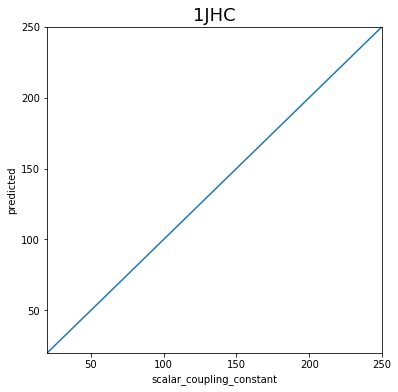

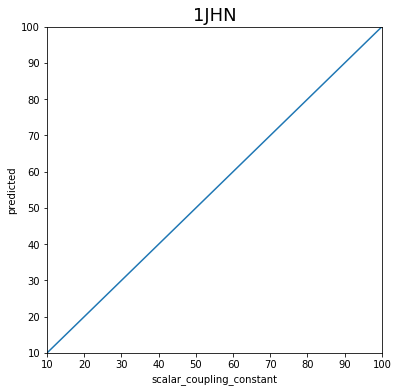

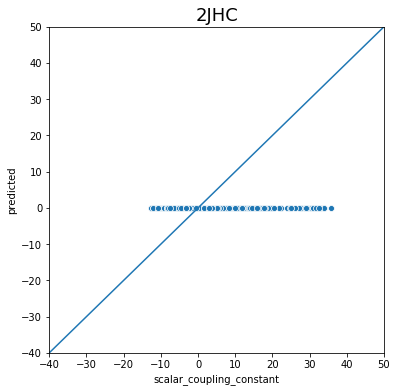

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f28b5a44c80> (for post_execute):


KeyboardInterrupt: 

In [27]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = train_preds
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 20, 250)
plot_oof_preds('1JHN', 10, 100)
plot_oof_preds('2JHC', -40, 50)
plot_oof_preds('2JHH', -50, 30)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -40, 90)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -10, 15)